# DREAMER Evaluation

Using leave one subject out, evaluate EEG-only spectral power and topo-based features.

In [1]:
import sys
sys.path.insert(0, "../")
save_prefix = "dreamer"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os, pickle
from tqdm import tqdm
from joblib import Parallel, delayed

from libs.dataloaders import dreamer

from sklearn.decomposition import PCA

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-92983jje because the default path (/home/anp054/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
def per_subject_cv(dataset, subject_sessions:list, model:list, n_jobs=12):
    """
    Run per subject validation using `model`
    Notes:
        - Does _not_ enforce train data balancing, but sets equal priors (assumes data is roughly balanced)
        - Enforce test data; skip fold when per-label count < 3
    @param dataset - DEAP dataset
    @param list subject_sessions - subjects or sessions; used for LOO
    @param fn model - model to use for training; this should be the class, not the instance
    @param int n_jobs - number of parallel jobs to run
    """
    dataset_seqs = len(dataset)
    dataset_feats = np.prod(np.shape(dataset[0][0][0]))
    pc_sweep_list = np.arange(1, min(dataset_seqs, dataset_feats+1))
    
    def _thread_worker(session, k_bootstrap, npc, X_train_pc, Y_train_vgg, X_test_pc, Y_test_vgg):
        def default_return(msg=""):
            return (session, k_bootstrap, npc), msg

        if len(Y_train_vgg) == 0 or len(Y_test_vgg) == 0:
            return default_return("Skipping: Y train or Y test having no values")
        
        unique_info = np.unique(Y_train_vgg, return_counts=True)
        if len(unique_info[0]) != 2:
            return default_return(f"Skipping: exactly 2 classes not detected")
        if min(unique_info[-1]) < 3:
            return default_return("Skipping: fewer than 3 samples per class detected")

        model_inst = model()
        model_inst.fit(X_train_pc[:,:npc], Y_train_vgg)
        model_train = model_inst.score(X_train_pc[:,:npc], Y_train_vgg)
        model_test = model_inst.score(X_test_pc[:,:npc], Y_test_vgg)

        return (session, k_bootstrap, npc), (pca.explained_variance_ratio_, model_train, model_test)

    # Generate parameter set of parallelization
    results = []
    for session in tqdm(subject_sessions):
        data_idx = [i for i in range(len(dataset)) if dataset.sessions[i] == session]
        job_list = []
        for k_bootstrap, test_idx in enumerate(tqdm(data_idx)):
            train_idx = [i for i in data_idx if i != test_idx]
            train_data = [dataset[i] for i in train_idx]
            X_train_vgg = np.array([i[0].flatten() for i in train_data])
            Y_train_vgg = np.squeeze([i[1] for i in train_data])*2-1 # rescale to -1, 1
            X_test_vgg = np.array([dataset[test_idx][0].flatten(), ])
            Y_test_vgg = np.array(dataset[test_idx][1])*2-1 # rescale to -1, 1
            
            if len(np.shape(Y_train_vgg)) == 0:
                Y_train_vgg = np.expand_dims(Y_train_vgg, axis=0)
            if len(np.shape(Y_test_vgg)) == 0:
                Y_test_vgg = np.expand_dims(Y_test_vgg, axis=0)
            
            # Shuffle train
            shuffle = np.random.permutation(np.arange(X_train_vgg.shape[0]))
            X_train_vgg = X_train_vgg[shuffle]
            Y_train_vgg = Y_train_vgg[shuffle]

            # Fit PC
            pca = PCA() # compute full pc
            pca.fit(X_train_vgg)
            X_train_pc = pca.transform(X_train_vgg)
            X_test_pc = pca.transform(X_test_vgg)
            
            job_list.extend([
                (session, k_bootstrap, npc, 
                    X_train_pc, Y_train_vgg, X_test_pc, Y_test_vgg,
                ) for npc in pc_sweep_list])
        
        # Run model computations
        # partial_results = [_thread_worker(*job) for job in tqdm(job_list)]
        partial_results = Parallel(n_jobs=n_jobs, backend="threading", verbose=1)(delayed(_thread_worker)(*job) for job in job_list)
        results.extend(partial_results)

    # Results objects
    train_accs = np.empty((len(subject_sessions), len(pc_sweep_list), max(np.unique(dataset.sessions, return_counts=True)[1]))) # n_subjects -> n_pc -> bootstrap
    train_accs[:] = np.nan
    test_accs = train_accs.copy()
    evs = np.empty((len(subject_sessions), max(pc_sweep_list))) # n_subjects -> max(pc_list)
    evs[:] = np.nan

    # Consolidate results
    for n_session, session in enumerate(subject_sessions):
        session_result = [i for i in results if i[0][0] == session]
        max_npc = max(pc_sweep_list)
        for n_npc, npc in enumerate(pc_sweep_list):
            npc_result = [i for i in session_result if i[0][2] == npc]
            for k_bootstrap in npc_result:
                if type(k_bootstrap[1]) is not str:
                    train_accs[n_session, n_npc, k_bootstrap[0][1]] = k_bootstrap[1][1]
                    test_accs[n_session, n_npc, k_bootstrap[0][1]] = k_bootstrap[1][2]
                    if npc == max_npc:
                        # across bootstraps values should be near identical
                        evs[n_session, :len(k_bootstrap[1][0])] = k_bootstrap[1][0]
    
    return train_accs, test_accs, evs

In [4]:
class RandomProjection:
    def __init__(self, n_components, center=0, scale=None):
        self.n_components = n_components
        self.projection_matrix = None
        self._center = center
        self._scale = scale

    def fit(self, data):
        if self._scale is None:
            self._scale = 1 / np.sqrt(data.shape[1])
        ## Approach 1
        self.projection_matrix = np.random.normal(self._center, self._scale, (data.shape[1], self.n_components))
        ## Approach 2
        # self.projection_matrix = np.random.normal(self._center, self._scale, (data.shape[1]*self.n_components,))
        # self.projection_matrix = np.reshape(self.projection_matrix, (data.shape[1], self.n_components))
        ## Approach 3
        # self.projection_matrix = np.zeros((data.shape[1]*self.n_components,))
        # for i in range(0, len(self.projection_matrix), 64_000):
        #     self.projection_matrix[i:i+64_000] = np.random.normal(self._center, self._scale, 64_000)
        # mod = len(self.projection_matrix) % 64_000
        # if mod > 0:
        #     self.projection_matrix[-mod:] = np.random.normal(self._center, self._scale, mod)
        # self.projection_matrix = np.reshape(self.projection_matrix, (data.shape[1], self.n_components))
    
    def transform(self, data):
        return np.dot(data, self.projection_matrix)
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [5]:
def per_subject_cv_rp_pc(dataset, subject_sessions:list, model:list, n_jobs=12, nrp=4096):
    """
    Run leave one subject out cross-validation on data transformed by random projection and then projected using PCA
    Notes:
        - Does _not_ enforce train data balancing, but sets equal priors (assumes data is roughly balanced)
        - Enforce test data; skip fold when per-label count < 3
    @param dataset - DEAP dataset
    @param list subject_sessions - subjects or sessions; used for LOO
    @param fn model - model to use for training; this should be the class, not the instance
    @param int n_jobs - number of parallel jobs to run
    @param int nrp - Random Projection component dimensionality
    """
    dataset_seqs = len(dataset)
    dataset_feats = np.prod(np.shape(dataset[0][0][0]))
    pc_sweep_list = np.arange(1, min(dataset_seqs, nrp))
    
    def _thread_worker(session, k_bootstrap, npc, X_train_pc, Y_train_vgg, X_test_pc, Y_test_vgg):
        def default_return(msg=""):
            return (session, k_bootstrap, npc), msg

        if len(Y_train_vgg) == 0 or len(Y_test_vgg) == 0:
            return default_return("Skipping: Y train or Y test having no values")
        
        unique_info = np.unique(Y_train_vgg, return_counts=True)
        if len(unique_info[0]) != 2:
            return default_return(f"Skipping: exactly 2 classes not detected")
        if min(unique_info[-1]) < 3:
            return default_return("Skipping: fewer than 3 samples per class detected")

        model_inst = model()
        model_inst.fit(X_train_pc[:,:npc], Y_train_vgg)
        model_train = model_inst.score(X_train_pc[:,:npc], Y_train_vgg)
        model_test = model_inst.score(X_test_pc[:,:npc], Y_test_vgg)

        return (session, k_bootstrap, npc), (pca.explained_variance_ratio_, model_train, model_test)

    # Generate parameter set of parallelization
    results = []
    for session in tqdm(subject_sessions):
        data_idx = [i for i in range(len(dataset)) if dataset.sessions[i] == session]
        # Compute one random projection on all of the data and then permute the projection
        # matrix itself. It takes ~25sec to generate one matrix when >1B samples.
        # This doesn't leak test data as it is just ensuring the sampling dist is centered
        rp_data = [dataset[i] for i in data_idx]
        X_rp = np.array([i[0].flatten() for i in rp_data])
        print(f"Computing Random Projection Matrix ({X_rp.shape[1]}, {nrp})")
        projection = RandomProjection(n_components=nrp)
        projection.fit(X_rp)

        job_list = []
        for k_bootstrap, test_idx in enumerate(tqdm(data_idx)):
            train_idx = [i for i in data_idx if i != test_idx]
            train_data = [dataset[i] for i in train_idx]
            X_train_vgg = np.array([i[0].flatten() for i in train_data])
            Y_train_vgg = np.squeeze([i[1] for i in train_data])*2-1 # rescale to -1, 1
            X_test_vgg = np.array([dataset[test_idx][0].flatten(), ])
            Y_test_vgg = np.array(dataset[test_idx][1])*2-1 # rescale to -1, 1
            # compute new projection based on original sampling
            np.random.shuffle(projection.projection_matrix) 
            X_train_rp = projection.transform(X_train_vgg)
            X_test_rp = projection.transform(X_test_vgg)
            
            if len(np.shape(Y_train_vgg)) == 0:
                Y_train_vgg = np.expand_dims(Y_train_vgg, axis=0)
            if len(np.shape(Y_test_vgg)) == 0:
                Y_test_vgg = np.expand_dims(Y_test_vgg, axis=0)
            
            # Shuffle train
            shuffle = np.random.permutation(np.arange(X_train_rp.shape[0]))
            X_train_rp = X_train_rp[shuffle]
            Y_train_vgg = Y_train_vgg[shuffle]

            # Fit PC
            pca = PCA() # compute full pc
            pca.fit(X_train_rp)
            X_train_pc = pca.transform(X_train_rp)
            X_test_pc = pca.transform(X_test_rp)
            
            job_list.extend([
                (session, k_bootstrap, npc, 
                    X_train_pc, Y_train_vgg, X_test_pc, Y_test_vgg,
                ) for npc in pc_sweep_list])
        
        # Run model computations
        # partial_results = [_thread_worker(*job) for job in tqdm(job_list)]
        partial_results = Parallel(n_jobs=n_jobs, backend="threading", verbose=1)(delayed(_thread_worker)(*job) for job in job_list)
        results.extend(partial_results)

    # Results objects
    train_accs = np.empty((len(subject_sessions), len(pc_sweep_list), max(np.unique(dataset.sessions, return_counts=True)[1]))) # n_subjects -> n_pc -> bootstrap
    train_accs[:] = np.nan
    test_accs = train_accs.copy()
    evs = np.empty((len(subject_sessions), max(pc_sweep_list))) # n_subjects -> max(pc_list)
    evs[:] = np.nan

    # Consolidate results
    for n_session, session in enumerate(subject_sessions):
        session_result = [i for i in results if i[0][0] == session]
        max_npc = max(pc_sweep_list)
        for n_npc, npc in enumerate(pc_sweep_list):
            npc_result = [i for i in session_result if i[0][2] == npc]
            for k_bootstrap in npc_result:
                if type(k_bootstrap[1]) is not str:
                    train_accs[n_session, n_npc, k_bootstrap[0][1]] = k_bootstrap[1][1]
                    test_accs[n_session, n_npc, k_bootstrap[0][1]] = k_bootstrap[1][2]
                    if npc == max_npc:
                        # across bootstraps values should be near identical
                        evs[n_session, :len(k_bootstrap[1][0])] = k_bootstrap[1][0]
    
    return train_accs, test_accs, evs

In [6]:
def trainmax2test(train, test):
    '''subject pc bootstrap -> subject bootstrap'''
    ## Max with fewest nPC
    # _train = np.nanmean(train, axis=2) # avg on bootstrap
    # _train = np.nan_to_num(_train, nan=-1.) # hacky way to get around all nan argmax
    # _argmax = np.argmax(_train, axis=1) # find max acc per pc
    # return np.array([subj[_argmax[n_subj], :] for n_subj, subj in enumerate(test)])

    ## Max with most nPC
    # _train = np.nanmean(train, axis=2) # avg on bootstrap
    # _train = np.nan_to_num(_train, nan=-1.) # hacky way to get around all nan argmax
    # _train = np.flip(_train, axis=1)
    # _argmax = np.argmax(_train, axis=1) # find max acc per pc
    # _test = np.flip(test, axis=1)
    # _test = np.array([subj[_argmax[n_subj], :] for n_subj, subj in enumerate(_test)])
    # _test = np.flip(_test, axis=1)
    # return _test

    ## Max with most nPC
    _train = np.nan_to_num(train, nan=-1.) # hacky way to get around all nan argmax
    _train = np.flip(_train, axis=1)
    _argmax = np.argmax(_train, axis=1) # find max acc per pc
    _test = np.flip(test, axis=1)
    return np.array([[k[_argmax[n_subj, n_k]] for n_k, k in enumerate(subj.T)] for n_subj, subj in enumerate(_test)])

def plot_overview(train, test, ev, dataset=None, dataset_clip=10):
    mdl_accs = trainmax2test(train, test)

    if dataset is not None:
        print(f"Clipping datasets with fewer than {dataset_clip} samples...")
        valid_sessions_idx = np.argwhere(np.unique(dataset.sessions, return_counts=True)[1] >= 10).squeeze()
    else:
        valid_sessions_idx = np.arange(mdl_accs.shape[0])
    
    mdl_accs = mdl_accs[valid_sessions_idx,:]
    mdl_means = np.nanmean(mdl_accs, axis=1) # avg on bootstrap
    print(np.nanmean(mdl_means))
    mdl_stderr = np.nanstd(mdl_accs, axis=1) / np.sqrt(np.count_nonzero(~np.isnan(mdl_accs), axis=1))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.ylabel("Accuracy")

    plt.subplot(2,1,2)
    plt.plot(np.cumsum(ev, axis=-1).T)
    plt.xlabel("Subject")
    plt.ylabel("Exp Var")
    plt.show()

In [7]:
import torch
import torchvision.models as torchmodels
def vgg16_augment(model):
    model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-3])
def inception_augment(model):
    model = torch.nn.Sequential(*list(torchmodels.inception_v3(weights="DEFAULT").children())[:-3])

In [8]:
from functools import partial
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC, LinearSVC

lda = partial(LinearDiscriminantAnalysis, priors=[0.5, 0.5])
linear_svm = partial(LinearSVC)
nonlinear_svm = partial(SVC, kernel="rbf")
models = [lda, linear_svm, nonlinear_svm]
reduced_models = [lda, ]

## Average Spectral Power

Here we are looking at the average spectral power of Theta, Alpha, and Beta per channel, concatenated together to form the feature vector. The results here are reported for a set of classifiers.

In [9]:
dataset = dreamer.DreamerDataset(
    x_params={
        "feature": "AvgFreqPower",
    },
    sessions=None,
    y_mode='bimodal',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


In [10]:
train_acc, acc, evs = per_subject_cv(dataset, subjects, lda, n_jobs=24)

100%|██████████| 13/13 [00:00<00:00, 970.01it/s]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.6s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=24)]: Done 546 out of 546 | elapsed:    1.9s finished
100%|██████████| 14/14 [00:00<00:00, 489.87it/s]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152 tasks      | elapsed:    0.5s
[Parallel(n_jobs=24)]: Done 402 tasks      | elapsed:    1.4s
[Parallel(n_jobs=24)]: Done 588 out of 588 | elapsed:    1.9s finished
100%|██████████| 10/10 [00:00<00:00, 589.49it/s]
[Parallel(n_jobs=24)]: Using backend ThreadingBackend with 24 concurrent workers.
[Parallel(n_jobs=24)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=24)]: Done 152

In [11]:
with open(f"{save_prefix}_result_avgfreqpwr.pkl", "wb") as fout:
    pickle.dump({"acc": acc, 
                 "train_acc": train_acc,
                 "ev": evs}, fout)

In [11]:
acc.shape, train_acc.shape, evs.shape

((23, 42, 16), (23, 42, 16), (23, 42))

/tmp/ipykernel_36741/1502069214.py:36: RuntimeWarning: Mean of empty slice
  mdl_means = np.nanmean(mdl_accs, axis=1) # avg on bootstrap
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Clipping datasets with fewer than 10 samples...
0.5289298664298664


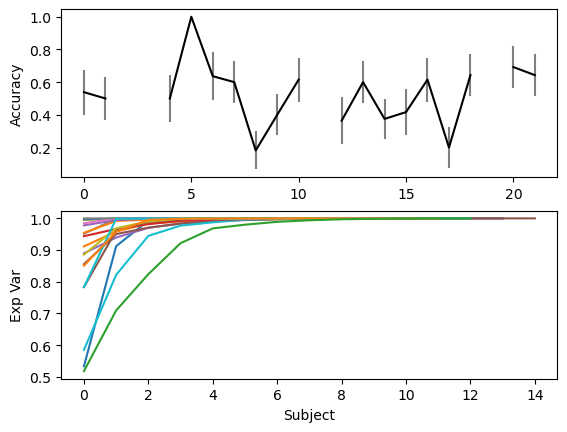

In [12]:
plot_overview(train_acc, acc, evs, dataset, dataset_clip=10)

In [29]:
mdl_accs = trainmax2test(train_acc, acc)

In [40]:
a = np.mean(mdl_accs, axis=0)
np.mean(a)
a

array([0.60869565, 0.43478261, 0.65217391, 0.52173913, 0.39130435,
       0.52173913, 0.30434783, 0.47826087, 0.52173913, 0.7826087 ,
       0.69565217, 0.47826087, 0.69565217, 0.56521739, 0.56521739,
       0.56521739, 0.60869565, 0.47826087])

In [35]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

In [37]:
np.mean(reject_outliers(a))

0.5489130434782609

## Spectrogram Image Feature - VGG16

In [ ]:
dataset = dreamer.DreamerDataset(
    x_params={
        "feature": "Spectrogram", 
        "model": "vgg16",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": vgg16_augment,
        "window": -1,
        "stride": -1
    },
    sessions=None,
    y_mode='split',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

In [ ]:
train_acc_specto, acc_specto, evs_specto = per_subject_cv(dataset, subjects, lda, n_jobs=64)

In [ ]:
with open(f"{save_prefix}_result_specto_vgg16.pkl", "wb") as fout:
    pickle.dump({"acc": acc_specto, 
                 "train_acc": train_acc_specto, 
                 "ev": evs_specto}, fout)

### PCA(RP_4096(Spectogram))

In [ ]:
train_acc_specto_rp_pc, acc_specto_rp_pc, ev_specto_rp_pc = \
    per_subject_cv_rp_pc(dataset, subjects, lda, n_jobs=24, nrp=4096)

In [ ]:
with open(f"{save_prefix}_result_specto_rp_pc.pkl", "wb") as fout:
    pickle.dump({"acc": acc_specto_rp_pc, 
                 "train_acc": train_acc_specto_rp_pc, 
                 "ev": ev_specto_rp_pc}, fout)

## Topo Features

Following methods outlined [here](https://ieeexplore.ieee.org/abstract/document/8713896/), Theta, Alpha, Beta frequency filtered topo images are combined into the three color channels and fed through pretrained image processing model. The performance results are reported as `Feat_Model -> PCA -> Model` and `Feat_model -> Model` as a function of features (ordered by EV for PCA and bootstrapped otherwise).

### VGG16

In [ ]:
dataset = dreamer.DreamerDataset(
    x_params={
        "feature": "TopomapNN",
        "model": "vgg16",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": vgg16_augment,
    },
    sessions=None,
    y_mode='split',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

In [ ]:
train_acc_vgg, acc_vgg, evs_vgg = per_subject_cv(dataset, subjects, lda, n_jobs=24)

In [ ]:
with open(f"{save_prefix}_result_vgg16.pkl", "wb") as fout:
    pickle.dump({"acc": acc_vgg, 
                 "train_acc": train_acc_vgg, 
                 "ev": evs_vgg, "models": reduced_models}, fout)

In [ ]:
plot_overview(train_acc_vgg, acc_vgg, evs_vgg, dataset, dataset_clip=10)

#### Strawman: Random Initialization
Using the VGG16 model architecture, initialize the weights randomly to measure the impact of architecture versus out-of-distribution trained performance.

In [ ]:
dataset = dreamer.DreamerDataset(
    x_params={
        "feature": "TopomapNN",
        "model": "vgg16",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": vgg16_augment,
        "random_weights": {
            "mode": "rand_init"
        },
    },
    sessions=None,
    y_mode='split',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

In [ ]:
train_acc_vgg_randinit, acc_vgg_randinit, evs_vgg_randinit = per_subject_cv(dataset, subjects, lda, n_jobs=64)

In [ ]:
with open(f"{save_prefix}_result_vgg16_straw_randinit.pkl", "wb") as fout:
    pickle.dump({"acc": acc_vgg_randinit, 
                 "train_acc": train_acc_vgg_randinit, 
                 "ev": evs_vgg_randinit, "models": reduced_models}, fout)

In [ ]:
plot_overview(train_acc_vgg_randinit, acc_vgg_randinit, evs_vgg_randinit, dataset, dataset_clip=10)

### AlexNet

In [ ]:
dataset = dreamer.DreamerDataset(
    x_params={
        "feature": "TopomapNN",
        "model": "alexnet",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": vgg16_augment, # using same transform for alexnet
    },
    sessions=None,
    y_mode='split',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

In [ ]:
train_acc_alexnet, acc_alexnet, evs_alexnet = per_subject_cv(dataset, subjects, lda, n_jobs=64)

In [ ]:
with open(f"{save_prefix}_result_alexnet.pkl", "wb") as fout:
    pickle.dump({"acc": acc_alexnet, 
                 "train_acc": train_acc_alexnet,
                 "ev": evs_alexnet, "models": reduced_models}, fout)

In [ ]:
plot_overview(train_acc_alexnet, acc_alexnet, evs_alexnet, dataset, dataset_clip=10)

#### Strawman: Random Initialization

In [ ]:
dataset = dreamer.DreamerDataset(
    x_params={
        "feature": "TopomapNN",
        "model": "alexnet",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": vgg16_augment, # using same transform for alexnet
        "random_weights": {
            "mode": "rand_init"
        },
    },
    sessions=None,
    y_mode='split',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

In [ ]:
train_acc_alexnet_randinit, acc_alexnet_randinit, evs_alexnet_randinit = per_subject_cv(dataset, subjects, lda, n_jobs=64)

In [ ]:
with open(f"{save_prefix}_result_alexnet_straw_randinit.pkl", "wb") as fout:
    pickle.dump({"acc": acc_alexnet_randinit, 
                 "train_acc": train_acc_alexnet_randinit,
                 "ev": evs_alexnet_randinit, "models": reduced_models}, fout)

In [ ]:
plot_overview(train_acc_alexnet_randinit, acc_alexnet_randinit, evs_alexnet_randinit, dataset, dataset_clip=10)

### InceptionNet v3

In [ ]:
dataset = dreamer.DreamerDataset(
    x_params={
        "feature": "TopomapNN",
        "model": "inception_v3",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": inception_augment,
    },
    sessions=None,
    y_mode='split',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

In [ ]:
train_acc_incepv3, acc_incepv3, evs_incepv3 = per_subject_cv(dataset, subjects, lda, n_jobs=64)

In [ ]:
with open(f"{save_prefix}_result_incepv3.pkl", "wb") as fout:
    pickle.dump({"acc": acc_incepv3, 
                 "train_acc": train_acc_incepv3,
                 "ev": evs_incepv3, "models": reduced_models}, fout)

In [ ]:
plot_overview(train_acc_incepv3, acc_incepv3, evs_incepv3, dataset, dataset_clip=10)

#### Strawman: Random Initialization

In [ ]:
dataset = dreamer.DreamerDataset(
    x_params={
        "feature": "TopomapNN",
        "model": "inception_v3",
        "model_params": {
            "weights": "DEFAULT",
        },
        "model_augment_fn": inception_augment,
        "random_weights": {
            "mode": "rand_init"
        },
    },
    sessions=None,
    y_mode='split',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

In [ ]:
train_acc_incepv3_randinit, acc_incepv3_randinit, evs_incepv3_randinit = per_subject_cv(dataset, subjects, lda, n_jobs=64)

In [ ]:
with open(f"{save_prefix}_result_incepv3_straw_randinit.pkl", "wb") as fout:
    pickle.dump({"acc": acc_incepv3_randinit,
                 "train_acc": train_acc_incepv3_randinit,
                 "ev": evs_incepv3_randinit, "models": reduced_models}, fout)

In [ ]:
plot_overview(train_acc_incepv3_randinit, acc_incepv3_randinit, evs_incepv3_randinit, dataset, dataset_clip=10)

## Random Projections
Here we explore whether deep feature transformers operate differently than high-dimensional random projections.

In [ ]:
class RandomProjection:
    def __init__(self, n_components, center=0, scale=None):
        self.n_components = n_components
        self.projection_matrix = None
        self._center = center
        self._scale = scale

    def fit(self, data):
        if self._scale is None:
            self._scale = 1 / np.sqrt(data.shape[1])
        ## Approach 1
        self.projection_matrix = np.random.normal(self._center, self._scale, (data.shape[1], self.n_components))
        ## Approach 2
        # self.projection_matrix = np.random.normal(self._center, self._scale, (data.shape[1]*self.n_components,))
        # self.projection_matrix = np.reshape(self.projection_matrix, (data.shape[1], self.n_components))
        ## Approach 3
        # self.projection_matrix = np.zeros((data.shape[1]*self.n_components,))
        # for i in range(0, len(self.projection_matrix), 64_000):
        #     self.projection_matrix[i:i+64_000] = np.random.normal(self._center, self._scale, 64_000)
        # mod = len(self.projection_matrix) % 64_000
        # if mod > 0:
        #     self.projection_matrix[-mod:] = np.random.normal(self._center, self._scale, mod)
        # self.projection_matrix = np.reshape(self.projection_matrix, (data.shape[1], self.n_components))
    
    def transform(self, data):
        return np.dot(data, self.projection_matrix)
    
    def fit_transform(self, data):
        self.fit(data)
        return self.transform(data)

In [ ]:
def per_subject_cv_rp_pc(dataset, subject_sessions:list, model:list, n_jobs=12, nrp=4096):
    """
    Run leave one subject out cross-validation on data transformed by random projection and then projected using PCA
    Notes:
        - Does _not_ enforce train data balancing, but sets equal priors (assumes data is roughly balanced)
        - Enforce test data; skip fold when per-label count < 3
    @param dataset - DEAP dataset
    @param list subject_sessions - subjects or sessions; used for LOO
    @param fn model - model to use for training; this should be the class, not the instance
    @param int n_jobs - number of parallel jobs to run
    @param int nrp - Random Projection component dimensionality
    """
    dataset_seqs = len(dataset)
    dataset_feats = np.prod(np.shape(dataset[0][0][0]))
    pc_sweep_list = np.arange(1, min(dataset_seqs, nrp))
    
    def _thread_worker(session, k_bootstrap, npc, X_train_pc, Y_train_vgg, X_test_pc, Y_test_vgg):
        def default_return(msg=""):
            return (session, k_bootstrap, npc), msg

        if len(Y_train_vgg) == 0 or len(Y_test_vgg) == 0:
            return default_return("Skipping: Y train or Y test having no values")
        
        unique_info = np.unique(Y_train_vgg, return_counts=True)
        if len(unique_info[0]) != 2:
            return default_return(f"Skipping: exactly 2 classes not detected")
        if min(unique_info[-1]) < 3:
            return default_return("Skipping: fewer than 3 samples per class detected")

        model_inst = model()
        model_inst.fit(X_train_pc[:,:npc], Y_train_vgg)
        model_train = model_inst.score(X_train_pc[:,:npc], Y_train_vgg)
        model_test = model_inst.score(X_test_pc[:,:npc], Y_test_vgg)

        return (session, k_bootstrap, npc), (pca.explained_variance_ratio_, model_train, model_test)

    # Generate parameter set of parallelization
    results = []
    for session in tqdm(subject_sessions):
        data_idx = [i for i in range(len(dataset)) if dataset.sessions[i] == session]
        # Compute one random projection on all of the data and then permute the projection
        # matrix itself. It takes ~25sec to generate one matrix when >1B samples.
        # This doesn't leak test data as it is just ensuring the sampling dist is centered
        rp_data = [dataset[i] for i in data_idx]
        X_rp = np.array([i[0].flatten() for i in rp_data])
        print(f"Computing Random Projection Matrix ({X_rp.shape[1]}, {nrp})")
        projection = RandomProjection(n_components=nrp)
        projection.fit(X_rp)

        job_list = []
        for k_bootstrap, test_idx in enumerate(tqdm(data_idx)):
            train_idx = [i for i in data_idx if i != test_idx]
            train_data = [dataset[i] for i in train_idx]
            X_train_vgg = np.array([i[0].flatten() for i in train_data])
            Y_train_vgg = np.squeeze([i[1] for i in train_data])*2-1 # rescale to -1, 1
            X_test_vgg = np.array([dataset[test_idx][0].flatten(), ])
            Y_test_vgg = np.array(dataset[test_idx][1])*2-1 # rescale to -1, 1
            # compute new projection based on original sampling
            np.random.shuffle(projection.projection_matrix) 
            X_train_rp = projection.transform(X_train_vgg)
            X_test_rp = projection.transform(X_test_vgg)
            
            if len(np.shape(Y_train_vgg)) == 0:
                Y_train_vgg = np.expand_dims(Y_train_vgg, axis=0)
            if len(np.shape(Y_test_vgg)) == 0:
                Y_test_vgg = np.expand_dims(Y_test_vgg, axis=0)
            
            # Shuffle train
            shuffle = np.random.permutation(np.arange(X_train_rp.shape[0]))
            X_train_rp = X_train_rp[shuffle]
            Y_train_vgg = Y_train_vgg[shuffle]

            # Fit PC
            pca = PCA() # compute full pc
            pca.fit(X_train_rp)
            X_train_pc = pca.transform(X_train_rp)
            X_test_pc = pca.transform(X_test_rp)
            
            job_list.extend([
                (session, k_bootstrap, npc, 
                    X_train_pc, Y_train_vgg, X_test_pc, Y_test_vgg,
                ) for npc in pc_sweep_list])
        
        # Run model computations
        # partial_results = [_thread_worker(*job) for job in tqdm(job_list)]
        partial_results = Parallel(n_jobs=n_jobs, backend="threading", verbose=1)(delayed(_thread_worker)(*job) for job in job_list)
        results.extend(partial_results)

    # Results objects
    train_accs = np.empty((len(subject_sessions), len(pc_sweep_list), max(np.unique(dataset.sessions, return_counts=True)[1]))) # n_subjects -> n_pc -> bootstrap
    train_accs[:] = np.nan
    test_accs = train_accs.copy()
    evs = np.empty((len(subject_sessions), max(pc_sweep_list))) # n_subjects -> max(pc_list)
    evs[:] = np.nan

    # Consolidate results
    for n_session, session in enumerate(subject_sessions):
        session_result = [i for i in results if i[0][0] == session]
        max_npc = max(pc_sweep_list)
        for n_npc, npc in enumerate(pc_sweep_list):
            npc_result = [i for i in session_result if i[0][2] == npc]
            for k_bootstrap in npc_result:
                if type(k_bootstrap[1]) is not str:
                    train_accs[n_session, n_npc, k_bootstrap[0][1]] = k_bootstrap[1][1]
                    test_accs[n_session, n_npc, k_bootstrap[0][1]] = k_bootstrap[1][2]
                    if npc == max_npc:
                        # across bootstraps values should be near identical
                        evs[n_session, :len(k_bootstrap[1][0])] = k_bootstrap[1][0]
    
    return train_accs, test_accs, evs

In [ ]:
dataset = dreamer.DreamerDataset(
    x_params={
        "feature": "TopomapImg",
    },
    sessions=None,
    y_mode='split',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

### PCA(RP_4096(Topo))

In [ ]:
train_acc_rp_pc, acc_rp_pc, ev_rp_pc = \
    per_subject_cv_rp_pc(dataset, subjects, lda, n_jobs=24, nrp=4096)

In [ ]:
with open(f"{save_prefix}_result_rp_pc.pkl", "wb") as fout:
    pickle.dump({"acc": acc_rp_pc, 
                 "train_acc": train_acc_rp_pc, 
                 "ev": ev_rp_pc, "models": reduced_models}, fout)

In [ ]:
plot_overview(train_acc_rp_pc, acc_rp_pc, ev_rp_pc, dataset, dataset_clip=10)

### Strawman: PCA(Topo) without RP

In [ ]:
train_acc_topo, acc_topo, ev_topo = per_subject_cv(dataset, subjects, lda, n_jobs=64)

In [ ]:
with open(f"{save_prefix}_result_topo.pkl", "wb") as fout:
    pickle.dump({"acc": acc_topo,
                 "train_acc": train_acc_topo,
                 "ev": ev_topo, "models": reduced_models}, fout)

In [ ]:
plot_overview(train_acc_topo, acc_topo, ev_topo, dataset, dataset_clip=10)

### PCA(RP_270000(AvgPwr))

In [ ]:
dataset = dreamer.DreamerDataset(
    x_params={
        "feature": "AvgFreqPower",
    },
    sessions=None,
    y_mode='split',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))

In [ ]:
train_acc_avgpwr_rp_pc, acc_avgpwr_rp_pc, ev_avgpwr_rp_pc = \
    per_subject_cv_rp_pc(dataset, subjects, lda, n_jobs=64, nrp=270000)

In [ ]:
with open(f"{save_prefix}_result_avgfreqpwr_rp_pc.pkl", "wb") as fout:
    pickle.dump({"acc": acc_avgpwr_rp_pc,
                 "train_acc": train_acc_avgpwr_rp_pc,
                 "ev": ev_avgpwr_rp_pc, "models": reduced_models}, fout)

In [ ]:
plot_overview(train_acc_avgpwr_rp_pc, acc_avgpwr_rp_pc, ev_avgpwr_rp_pc, dataset, dataset_clip=10)

# Metrics

The metrics here are shown aggregated by subject (stderr bars are on the subject variance). Subjects with fewer than 10 samples are excluded from calculations.

In [ ]:
import pickle
from matplotlib import pyplot as plt
import seaborn as sns

## Standard vs DFT
1. Are standard features comparable to deep feature transformer?

In [ ]:
with open(f'{save_prefix}_result_avgfreqpwr.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_std = d['acc'] # ch representation of deatures
    res_train_std = d['train_acc'] # ch representation of deatures

with open(f'{save_prefix}_result_topo.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_topo = d['acc'] # topo representation of features
    res_train_topo = d['train_acc'] # topo representation of features

with open(f'{save_prefix}_result_specto_vgg16.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_specto = d['acc'] # topo representation of features
    res_train_specto = d['train_acc'] # topo representation of features

with open(f'{save_prefix}_result_vgg16.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_vgg16_pt = d['acc'] # pretrained
    res_train_vgg16_pt = d['train_acc'] # pretrained

In [ ]:
def gen_y(aggop_subj, session_mask=None):
    y = np.array([
        trainmax2test(res_train_std, res_std),
        trainmax2test(res_train_topo, res_topo),
        trainmax2test(res_train_specto, res_specto),
        trainmax2test(res_train_vgg16_pt, res_vgg16_pt),
    ]) # 4 -> Subjects -> Bootstrap
    y = np.nanmean(y, axis=-1) # 4 -> Subjects

    if session_mask is not None:
        y = y[:, session_mask]
    
    means = aggop_subj(y, axis=-1)
    stderrs = np.nanstd(y, axis=-1)/np.sqrt(np.count_nonzero(~np.isnan(y), axis=-1))
    return means, stderrs

valid_sessions_idx = np.argwhere(np.unique(dataset.sessions, return_counts=True)[1] >= 10).squeeze()
y_mean, yerr_mean  = gen_y(np.nanmean, valid_sessions_idx)
y_median, yerr_median  = gen_y(np.nanmedian, valid_sessions_idx)
x = ["AvgFreqPwr", "AvgFreqPwr Topo", "VGG16 Specto", "VGG16 Topo"]

In [ ]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(x)), y_mean, yerr=yerr_mean, align='center', alpha=0.5, ecolor='black', capsize=3)
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x)
ax.set_title("Mean Standard vs DFT")
ax.set_ylabel("Accuracy")
plt.show()

## DFT architectures + Pretrained vs Random (Xe) weights
1. Are there any differences between different DFT architectures
2. Do pretrained models provide any benefit over randomly initialized architectures?

In [ ]:
with open(f'{save_prefix}_result_vgg16.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_vgg16_pt = d['acc'] # pretrained
    res_train_vgg16_pt = d['train_acc'] # pretrained
with open(f'{save_prefix}_result_vgg16_straw_randinit.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_vgg16_ri = d['acc'] # rand init
    res_train_vgg16_ri = d['train_acc'] # rand init

with open(f'{save_prefix}_result_alexnet.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_alexnet_pt = d['acc'] # pretrained
    res_train_alexnet_pt = d['train_acc'] # pretrained
with open(f'{save_prefix}_result_alexnet_straw_randinit.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_alexnet_ri = d['acc'] # rand init
    res_train_alexnet_ri = d['train_acc'] # rand init

with open(f'{save_prefix}_result_incepv3.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_incepv3_pt = d['acc'] # pretrained
    res_train_incepv3_pt = d['train_acc'] # pretrained
with open(f'{save_prefix}_result_incepv3_straw_randinit.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_incepv3_ri = d['acc'] # rand init
    res_train_incepv3_ri = d['train_acc'] # rand init

In [ ]:
def gen_y(aggop_subj, session_mask=None):
    y = np.array([
        trainmax2test(res_train_vgg16_pt, res_vgg16_pt),
        trainmax2test(res_train_vgg16_ri, res_vgg16_ri),
        trainmax2test(res_train_alexnet_pt, res_alexnet_pt),
        trainmax2test(res_train_alexnet_ri, res_alexnet_ri),
        trainmax2test(res_train_incepv3_pt, res_incepv3_pt),
        trainmax2test(res_train_incepv3_ri, res_incepv3_ri),
    ]) # 6 -> Subjects -> Bootstrap
    y = np.nanmean(y, axis=-1) # 6 -> Subjects

    if session_mask is not None:
        y = y[:, session_mask]

    means = aggop_subj(y, axis=-1)
    stderrs = np.nanstd(y, axis=-1)/np.sqrt(np.count_nonzero(~np.isnan(y), axis=-1))
    return means, stderrs

valid_sessions_idx = np.argwhere(np.unique(dataset.sessions, return_counts=True)[1] >= 10).squeeze()
y_mean, yerr_mean  = gen_y(np.nanmean, valid_sessions_idx)
y_median, yerr_median  = gen_y(np.nanmedian, valid_sessions_idx)
x = ["VGG16", "VGG16 Rand", "AlexNet", "AlexNet Rand", "IncepV3", "IncepV3 Rand"]

In [ ]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(x)), y_mean, yerr=yerr_mean, align='center', alpha=0.5, ecolor='black', capsize=3)
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x)
ax.set_title("Mean Architecture Comparison")
ax.set_ylabel("Accuracy")
plt.show()

## Random Projections vs DFT

In [ ]:
with open(f'{save_prefix}_result_rp_pc.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_rp = d['acc']
    res_train_rp = d['train_acc']

with open(f'{save_prefix}_result_avgfreqpwr_rp_pc.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_avgfreqpwr_rp_pc = d['acc']
    res_train_avgfreqpwr_rp_pc = d['train_acc']

with open(f'{save_prefix}_result_specto_rp_pc.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_specto_rp_pc = d['acc']
    res_train_specto_rp_pc = d['train_acc']

with open(f'{save_prefix}_result_vgg16.pkl', 'rb') as fin:
    d = pickle.load(fin)
    res_vgg16_pt = d['acc'] # pretrained
    res_train_vgg16_pt = d['train_acc'] # pretrained

In [ ]:
def gen_y(aggop_subj, session_mask=None):
    y = np.array([
        trainmax2test(res_train_rp, res_rp),
        trainmax2test(res_train_avgfreqpwr_rp_pc, res_avgfreqpwr_rp_pc),
        trainmax2test(res_train_specto_rp_pc, res_specto_rp_pc),
        trainmax2test(res_train_vgg16_pt, res_vgg16_pt),
    ]) # 4 -> Subjects -> Bootstrap
    y = np.nanmean(y, axis=-1) # 4 -> Subjects

    if session_mask is not None:
        y = y[:, session_mask]

    means = aggop_subj(y, axis=-1)
    stderrs = np.nanstd(y, axis=-1)/np.sqrt(np.count_nonzero(~np.isnan(y), axis=-1))
    return means, stderrs

valid_sessions_idx = np.argwhere(np.unique(dataset.sessions, return_counts=True)[1] >= 10).squeeze()
y_mean, yerr_mean  = gen_y(np.nanmean, valid_sessions_idx)
y_median, yerr_median  = gen_y(np.nanmedian, valid_sessions_idx)
x = ["RP(Topo)", "RP(AvgFreq)", "RP(Specto)", "VGG16(Topo)"]

In [ ]:
fig, ax = plt.subplots()
ax.bar(np.arange(len(x)), y_mean, yerr=yerr_mean, align='center', alpha=0.5, ecolor='black', capsize=3)
ax.set_xticks(np.arange(len(x)))
ax.set_xticklabels(x)
ax.set_title("Mean Architecture Comparison")
ax.set_ylabel("Accuracy")
plt.show()